# Introduction

In this notebook, I'll implement simple RNNs, then explore how gradients flow through this network.

# Imports


In [ ]:
! pip install ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.3 MB/s eta 0:00:00


In [ ]:
import copy

# If you are not using colab you can delete these two lines
from google.colab import output
output.enable_custom_widget_manager()

import torch as th
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets, Layout

In [ ]:
%matplotlib ipympl

# 1.A: implementing a RNN layer


In [ ]:
class RNNLayer(nn.Module):
  def __init__(self, input_size, hidden_size, nonlinearity=th.tanh):
    """
    Initialize a single RNN layer.

    Inputs:
    - input_size: Data input feature dimension
    - hidden_size: RNN hidden state size (also the output feature dimension)
    - nonlinearity: Nonlinearity applied to the rnn output
    """
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.nonlinearity = nonlinearity
    self.lin1 = nn.Linear(self.input_size, self.hidden_size, bias=False)
    self.lin2 = nn.Linear(self.hidden_size, self.hidden_size)

  def forward(self, x):
    """
    RNN forward pass

    Inputs:
    - x: input tensor (B, seq_len, input_size)

    Returns:
    - all_h: tensor of size (B, seq_len, hidden_size) containing hidden states
             produced for each timestep
    - last_h: hidden state from the last timestep (B, hidden_size)
    """
    h_list = []  # List to store the hidden states [h_1, ... h_T]

    ##############################################################################
    # Implementation of the RNN forward step                                     #
    ##############################################################################
    B, seq_len, input_size = x.size()
    h_list.append(th.zeros((B, self.hidden_size)))
    last_h = th.zeros((B, self.hidden_size))

    for j in range(0, seq_len):
        state = self.nonlinearity(self.lin1(x[:, j, :]) + self.lin2(h_list[j]))
        h_list.append(state)
        if j == seq_len - 1:
          last_h = state

    # h_list should now contain all hidden states, each of size (B, hidden_size)
    # We will store the hidden states so we can analyze their gradients later
    self.store_h_for_grad(h_list[1:])
    all_h = th.stack(h_list[1:], dim=1)
    return all_h, last_h

  def store_h_for_grad(self, h_list):
    """
    Store input list and allow gradient computation for all list elements
    """
    for h in h_list:
      h.retain_grad()
    self.h_list = h_list


### Test Cases


In [ ]:
rnn = RNNLayer(1, 1)
# Overwrite initial parameters with fixed values.
# Should give deterministic results even with different implementations.
rnn.load_state_dict({k: v * 0 + .1 for k, v in rnn.state_dict().items()})
data = th.ones((1, 1, 1))
expected_out = th.FloatTensor([[[0.1973753273487091]]])
all_h, last_h = rnn(data)
assert all_h.shape == expected_out.shape
assert th.all(th.isclose(all_h, last_h))
print(f'Expected: {expected_out.item()}, got: {last_h.item()}, max error: {th.max(th.abs(expected_out - last_h)).item()}')

rnn = RNNLayer(2, 3, nonlinearity=lambda x: x)  # no nonlinearity

num_params = sum(p.numel() for p in rnn.parameters())
assert num_params == 18, f'expected 18 parameters but found {num_params}'

rnn.load_state_dict({k: v * 0 - .1 for k, v in rnn.state_dict().items()})
data = th.FloatTensor([[[.1, .15], [.2, .25], [.3, .35], [.4, .45]], [[-.1, -1.5], [-.2, -2.5], [-.3, -3.5], [-.4, -.45]]])
expected_all_h = th.FloatTensor([[[-0.1250, -0.1250, -0.1250],
         [-0.1075, -0.1075, -0.1075],
         [-0.1328, -0.1328, -0.1328],
         [-0.1452, -0.1452, -0.1452]],

        [[ 0.0600,  0.0600,  0.0600],
         [ 0.1520,  0.1520,  0.1520],
         [ 0.2344,  0.2344,  0.2344],
         [-0.0853, -0.0853, -0.0853]]])
expected_last_h = th.FloatTensor([[-0.1452, -0.1452, -0.1452],
        [-0.0853, -0.0853, -0.0853]])
all_h, last_h = rnn(data)
assert all_h.shape == expected_all_h.shape
assert last_h.shape == expected_last_h.shape
print(f'Max error all_h: {th.max(th.abs(expected_all_h - all_h)).item()}')
print(f'Max error last_h: {th.max(th.abs(expected_last_h - last_h)).item()}')

Expected: 0.1973753273487091, got: 0.1973753273487091, max error: 0.0
Max error all_h: 4.999339580535889e-05
Max error last_h: 2.498924732208252e-05


# 1.B Implementing a RNN regression model.


In [ ]:
class RecurrentRegressionModel(nn.Module):
  def __init__(self, recurrent_net, output_dim=1):
    """
    Initialize a simple RNN regression model

    Inputs:
    - recurrent_net: an RNN or LSTM (single or multi layer)
    - output_dim: feature dimension of the output
    """
    super().__init__()
    self.recurrent_net = recurrent_net
    self.output_dim = output_dim

    self.lin = nn.Linear(recurrent_net.hidden_size, self.output_dim)

  def forward(self, x):
    """
    Forward pass

    Inputs:
    - x: input tensor (B, seq_len, input_size)

    Returns:
    - out: predictions of shape (B, seq_len, self.output_dim).
    - all_h: tensor of size (B, seq_len, hidden_size) containing hidden states
             produced for each timestep.
    """
    all_h, last_h = self.recurrent_net(x)
    out = self.lin(all_h)
    return out, all_h


## Tests

In [ ]:
rnn = RecurrentRegressionModel(RNNLayer(2, 3), 4)

num_params = sum(p.numel() for p in rnn.parameters())
assert num_params == 34, f'expected 34 parameters but found {num_params}'

rnn.load_state_dict({k: v * 0 - .1 for k, v in rnn.state_dict().items()})
data = th.FloatTensor([[[.1, .15], [.2, .25], [.3, .35], [.4, .45]], [[-.1, -1.5], [-.2, -2.5], [-.3, -3.5], [-.4, -.45]]])
expected_preds = th.FloatTensor([[[-0.0627, -0.0627, -0.0627, -0.0627],
         [-0.0678, -0.0678, -0.0678, -0.0678],
         [-0.0604, -0.0604, -0.0604, -0.0604],
         [-0.0567, -0.0567, -0.0567, -0.0567]],

        [[-0.1180, -0.1180, -0.1180, -0.1180],
         [-0.1453, -0.1453, -0.1453, -0.1453],
         [-0.1692, -0.1692, -0.1692, -0.1692],
         [-0.0748, -0.0748, -0.0748, -0.0748]]])
expected_all_h = th.FloatTensor([[[-0.1244, -0.1244, -0.1244],
         [-0.1073, -0.1073, -0.1073],
         [-0.1320, -0.1320, -0.1320],
         [-0.1444, -0.1444, -0.1444]],

        [[ 0.0599,  0.0599,  0.0599],
         [ 0.1509,  0.1509,  0.1509],
         [ 0.2305,  0.2305,  0.2305],
         [-0.0840, -0.0840, -0.0840]]])
preds, all_h = rnn(data)
print(expected_preds.size())
assert all_h.shape == expected_all_h.shape
assert preds.shape == expected_preds.shape
print(f'Max error all_h: {th.max(th.abs(expected_all_h - all_h)).item()}')
print(f'Max error last_h: {th.max(th.abs(expected_preds - preds)).item()}')

torch.Size([2, 4, 4])
torch.Size([2, 4, 4])
Max error all_h: 4.699826240539551e-05
Max error last_h: 4.3138861656188965e-05


# Problem 1.C: Dataset and loss function

## 1.C.i: Understanding the dataset


In [ ]:
def generate_batch(seq_len=10, batch_size=1):
  data = th.randn(size=(batch_size, seq_len, 1))
  sums = th.cumsum(data, dim=1)
  div = (th.arange(seq_len) + 1).unsqueeze(0).unsqueeze(2)
  target = sums / div

  return data, target

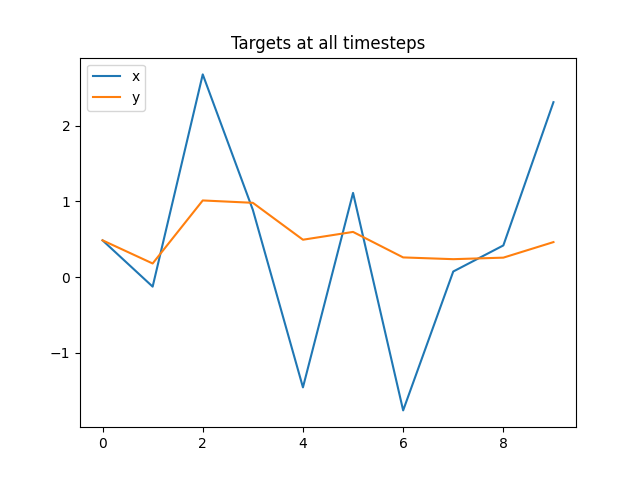

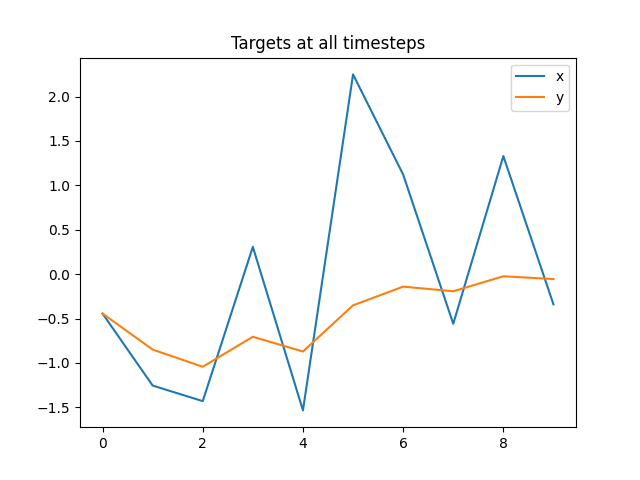

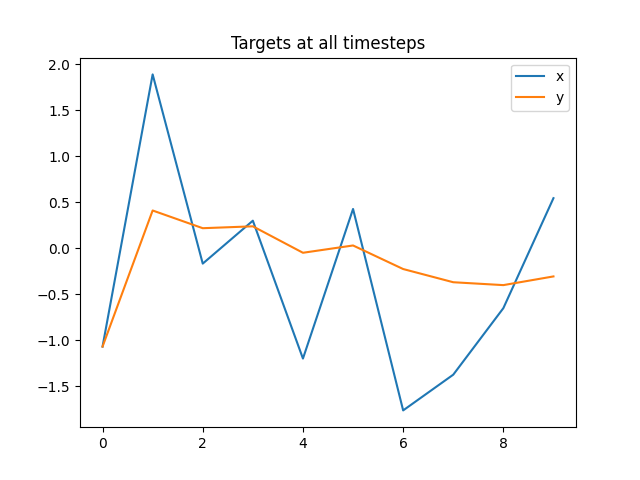

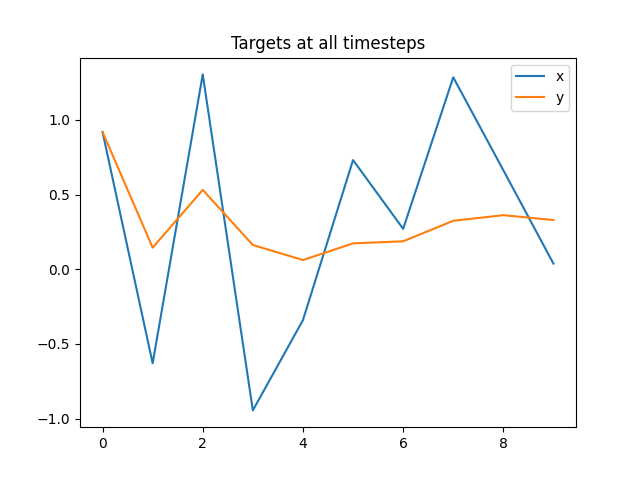

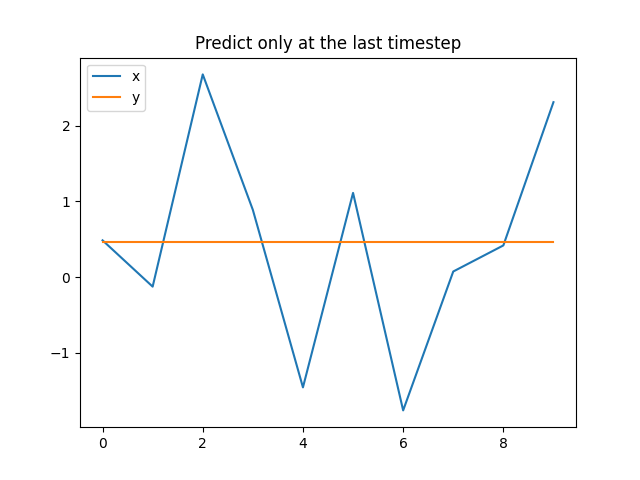

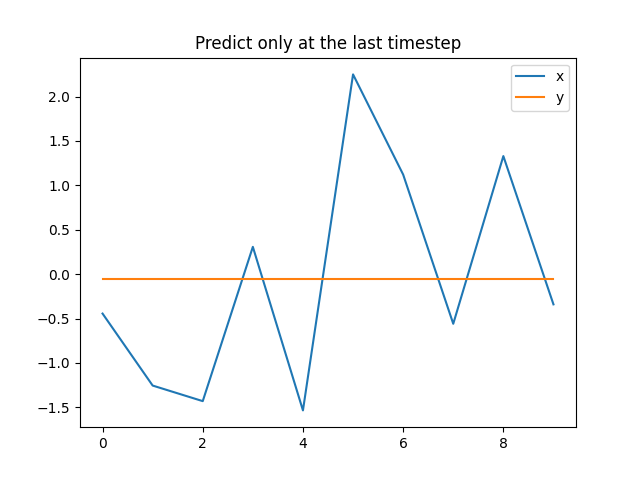

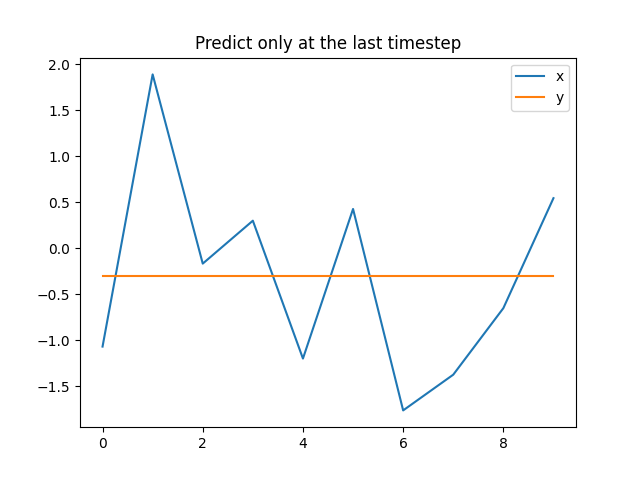

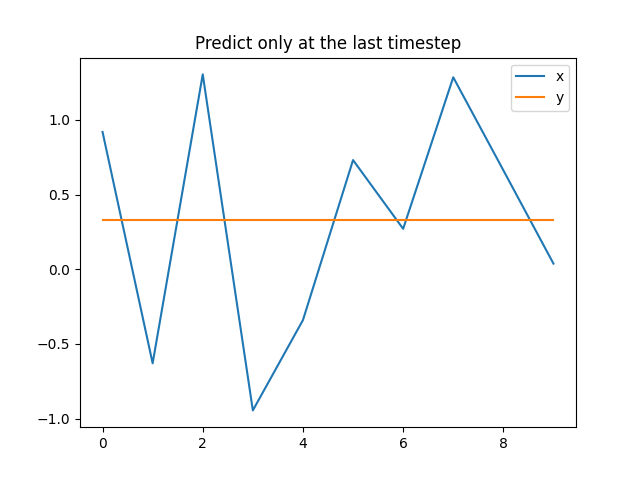

In [ ]:
x, y = generate_batch(seq_len=10, batch_size=4)
for i in range(4):
  fig, ax1 = plt.subplots(1)
  ax1.plot(x[i, :, 0])
  ax1.plot(y[i, :, 0])
  ax1.legend(['x', 'y'])
  plt.title('Targets at all timesteps')
  plt.show()

for i in range(4):
  fig, ax1 = plt.subplots(1)
  ax1.plot(x[i, :, 0])
  ax1.plot(np.arange(10), [y[i, -1].item()] * 10)
  ax1.legend(['x', 'y'])
  plt.title('Predict only at the last timestep')
  plt.show()

## 1.C.ii Implement the loss function

In [ ]:
def loss_fn(pred, y, last_timestep_only=False):
  """
  Inputs:
  - pred: model predictions of size (batch, seq_len, 1)
  - y: targets of size (batch, seq_len, 1)
  - last_timestep_only: boolean indicating whether to compute loss for all
    timesteps or only the lat

  Returns:
  - loss: scalar MSE loss between pred and true labels
  """
  ##############################################################################
  # Implementation of the loss                                                 #
  ##############################################################################
  criterion = nn.MSELoss()
  if last_timestep_only:
    loss = criterion(pred[:, -1], y[:, -1])
  else:
    loss = criterion(pred, y)
  return loss

### Tests
You should see errors < 1e-4

In [ ]:
pred = th.FloatTensor([[.1, .2, .3], [.4, .5, .6]])
y = th.FloatTensor([[-1.1, -1.2, -1.3], [-1.4, -1.5, -1.6]])
loss_all = loss_fn(pred, y, last_timestep_only=False)
loss_last = loss_fn(pred, y, last_timestep_only=True)
assert loss_all.shape == loss_last.shape == th.Size([])
print(f'Max error loss_all: {th.abs(loss_all - th.tensor(3.0067)).item()}')
print(f'Max error loss_last: {th.abs(loss_last - th.tensor(3.7)).item()}')

Max error loss_all: 3.314018249511719e-05
Max error loss_last: 2.384185791015625e-07


# 1.D: Analyzing RNN Gradients

You do not need to understand the details of the GradientVisualizer class in order to complete this problem.

In [ ]:
def biggest_eig_magnitude(matrix):
  """
  Inputs: a square matrix
  Returns: the scalar magnitude of the largest eigenvalue
  """
  h, w = matrix.shape
  assert h == w, f'Matrix has shape {matrix.shape}, but eigenvalues can only be computed for square matrices'
  eigs = th.linalg.eigvals(matrix)
  eig_magnitude = eigs.abs()
  eigs_sorted = sorted([i.item() for i in eig_magnitude], reverse=True)
  first_eig_magnitude = eigs_sorted[0]
  return first_eig_magnitude

class GradientVisualizer:

  def __init__(self, rnn, last_timestep_only):
    """
    Inputs:
    - rnn: rnn module
    - last_timestep_only: boolean indicating whether to compute loss for all
      timesteps or only the lat

    Returns:
    - loss: scalar MSE loss between pred and true labels
    """

    self.rnn = rnn
    self.last_timestep_only = last_timestep_only
    self.model = RecurrentRegressionModel(rnn)
    self.original_weights = copy.deepcopy(rnn.state_dict())

    # Generate a single batch to be used repeatedly
    self.x, self.y = generate_batch(seq_len=10)
    print(f'Data point: x={np.round(self.x[0, :, 0].detach().cpu().numpy(), 2)}, y={np.round(self.y.squeeze().detach().cpu().numpy(), 2)}')

  def plot_visuals(self):
    """ Generate plots which will be updated in realtime."""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('RNN Outputs')
    ax1.set_xlabel('Unroll Timestep')
    ax1.set_ylabel('Hidden State Norm')
    ax1.set_ylim(-1, 5)
    plt_1 = ax1.plot(np.arange(1, 11), np.zeros(10) + 1)  # placeholder vals
    plt_1 = plt_1[0]

    ax2.set_title('Gradients')
    ax2.set_xlabel('Unroll Timestep')
    ax2.set_ylabel('RNN dLoss/d a_t Gradient Magitude')
    ax2.set_ylim( (10**-6,1e5) )
    ax2.set_yscale('log')
    # X-axis labels are reversed since the gradient flow is from later layers to earlier layers
    ax2.set_xticks(np.arange(10), np.arange(10, 0, -1))
    plt_2 = ax2.plot(np.arange(10), np.arange(10) + 1)  # placeholder vals
    plt_2 = plt_2[0]
    self.fig = fig
    self.plots = [plt_1, plt_2]
    return plt_1, plt_2, fig

  # Main update function for interactive plot
  def update_plots(self, weight_val=0, bias_val=0):
    # Scale the original RNN weights by a constant
    w_dict = copy.deepcopy(self.original_weights)
    for k in w_dict.keys():
      if 'weight' in k:
        w_dict[k][:] *= weight_val
      elif 'bias' in k:
        w_dict[k][:] *= bias_val
    self.rnn.load_state_dict(w_dict)
    # Don't compute for LSTMs, which don't have behavior dependent on a single eigenvalue
    if isinstance(self.rnn, RNNLayer):
      W = self.rnn.lin2.weight
      biggest_eig = biggest_eig_magnitude(W)
      print(f' Biggest eigenvalue magnitude: {biggest_eig:.3}')

    # Run model
    pred, h = self.model(self.x)
    loss = loss_fn(pred, self.y, self.last_timestep_only)
    n_steps = len(h[0])

    plt_1, plt_2 = self.plots

    # Plot the hidden state magnitude
    max_h = th.linalg.norm(h[0], dim=-1).detach().cpu().numpy()
    print('Max H', ' '.join([f'{num:.3}' for num in max_h]))
    plt_1.set_data(np.arange(1, n_steps + 1), np.array(max_h))
    # Compute the gradient for the loss wrt the stored hidden states
    # Gradients are plotted backward since we go from later layers to earlier
    grads = [th.linalg.norm(num).item() for num in th.autograd.grad(loss, self.rnn.h_list)][::-1]
    print('gradients d Loss/d h_t', ' '.join([f'{num:.3}' for num in grads]))
    # Add 1e-6 since it throws an error for gradients near 0
    plt_2.set_data(np.arange(n_steps), np.array(grads) + 1e-6)
    self.fig.canvas.draw_idle()

  def create_visualization(self):
    # Include sliders for relevant quantities
    self.plot_visuals()
    ip = interactive(self.update_plots,
                    weight_val=widgets.FloatSlider(value=0, min=-5, max=5, step=.05, description="weight_scale", layout=Layout(width='100%')),
                    bias_val=widgets.FloatSlider(value=0, min=-5, max=5, step=.05, description="bias_scale", layout=Layout(width='100%')),
                    )
    return ip

Adjust the sliders rescale the weight and bias parameters in the RNN. Observe the effect on exploding and vanishing gradients.

Parameters to try varying:
*   nonlinearity
*   last_target_only



Data point: x=[-1.18  0.89 -0.34  0.82  0.43 -0.25 -0.9  -0.06 -0.96 -0.12], y=[-1.18 -0.15 -0.21  0.05  0.12  0.06 -0.07 -0.07 -0.17 -0.17]


interactive(children=(FloatSlider(value=0.0, description='weight_scale', layout=Layout(width='100%'), max=5.0,…

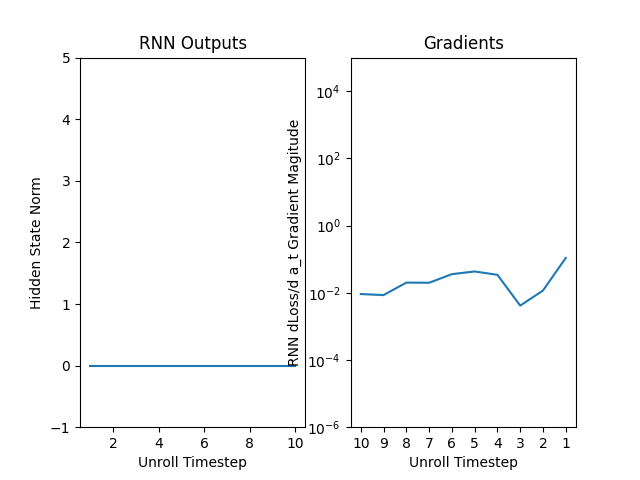

In [ ]:
hidden_size = 16
nonlinearity = lambda x: th.tanh(x)# options include lambda x: x (no nonlinearity), nn.functional.relu, and th.tanh
last_target_only = False
rnn = RNNLayer(1, hidden_size, nonlinearity=nonlinearity)
gv = GradientVisualizer(rnn, last_target_only)
gv.create_visualization()

# If for some reason the slider doesn't work for you, try calling gv.update_plots
# with various values for weight and bias


The previously defined architecture, faces the same challenges we face when using layers of $CNN$ mainly those of *dying gradients* and *exploding gradients*, due to the deep nature of this network.

There are several regularization techniques to deal with these challenges. But there's a subtle yet very important distinction we need to make, an explanation of the delicacy of $RNNs$ that goes beyond the argument *'They are just deep'*.

In the case of $RNNs$ we have two dynamical systems we need to make sure are stable.

The first one is that of the optimization dynamics. The gradient descent updates are a dynamical system, we have analysed the convergence  of such system (Through linearization) before, We know how to condition the optimization landscape and how to carefully tune the learning rate to allow for proper convergence.

Another challenge that is inherent to $RNNs$, is the fact that we are using a recurrent relationship in the information propagation, the shared weights and the recurrent relationship create another dynamical system that we would need to keep stable we can again analyse the linear case (Kalman filter), look at the previous equation:
$$\vec{h}_{t+1|t+1} = A\vec{h}_{t|t} + B\vec{x}_{t}$$
The eigenvalues of the matrix $A$ govern the stability of our information propagation system, the stability of these activations, itself  plays a role in the stability of the first system, if this one diverges, the gradient descent dynamical system diverges too.

You can see how there's a deep interplay, that makes dealing with $RNNs$ challenging and needs special delicacy to allow for proper learning.

When we view an $RNN$ as a dynamical system, we're essentially looking at how information evolves over time through repeated application of the same transformation. The key insight is that we want this system to be stable - meaning we don't want the hidden state values to grow unboundedly or chaotically over time sequences.

This stability requirement exists independently of gradient considerations:

- If hidden states explode, we lose meaningful information representation
- If they vanish, we lose the ability to maintain long-term dependencies
- Values less than one help ensure the system converges to meaningful attractors rather than diverging

What's elegant about this perspective is that it shows how the same solution (keeping values bounded) addresses two different but related problems:
1. *Forward pass stability (dynamical systems view)*
2. *Gradient stability (backpropagation view)*


>**TLDR**
>the activations affect gradients, which affect weight updates, which then affect future activations. *I can't believe we got RNNs to work.*

We will now explain some solutions to these challenges and how those solutions enforce necessary inductive biases.
##### To deal with exploding gradients:

*Solution 1:* We use saturating non-linearities.

These non-linearities will allow the output values of the activation function to have values lesser than one. An attentive reader might ask why we didn't have the same problem in other architectures where we used ReLUs, the answer is subtle yet very important.

A possible explanation is that since $RNNs$ are recurrent, the gradient would involve a lot of multiplication. Therefore, in order to prevent the gradient from exploding, we want to make sure the output value of the activation function would be smaller than one, since the the gradient magnitudes are directly affected by those of the activations.

Another perspective is that in $RNNs$, the information propagation in the forward pass is a dynamical system itself that we would need to stabilize, this is a problem specific to $RNNs$ since they are recurrent.

A fun, and philosophical way to look at this is that physical things in the real world, modelled as dynamics (linear or non-linear) can not run off to infinity, some kind of non-linearity will kick in and stop them, so an original belief in designing $RNNs$ which are essentially a dynamical system, odds are it shouldn't run to infinity either, so we add saturating non-linearities.

*Solution 2:* We use Normalization.

We can either use:
+ *Layer Normalization:* We can apply layer normalization in two ways in the context of $RNN$: either we normalize the $hs$ above, or, we can do the layer norm in the $x$ direction. We can also put layer norm inside $w_is$ ($MLP$), layer normalization makes sense in this context since we are just cantering and sphering the hidden states separately, there's no weird apples and oranges averaging in this case .
	+ If we apply the normalization between the layers (Horizontally), across all of the sequence, in training time it can easily work, since we have all of our sequences coming in. Now at test time, if we have all of our sequence coming in at the same time, then no problem. But if the sequence inputs come one at a time, we need some reparameterization to account for the statistics, so LayerNorm works, but it's application specific.
	+ If we put a 'mini' normalization horizontally, we don't have the same problem.
	+ We should also add learnable parameters and we need our data to be high dimensional enough so the distortion is not very significant.
+ *Batch Normalization:* we do not usually use Batch Normalization is because it would not consider the recurrent part of th e network, as in each recurrence calculation the statistics about the data would change. If you want to explore further, you can check [paper](https://arxiv.org/abs/1603.09025) and see how we do reparameterization to get Batch Normalization to work.

##### To deal with dying gradients:

*Solution:* Use skip connections to allow for a baseline to the gradient updates.

We have two options to add the skip connections:

+ Do ResNet skip connection in the vertical direction (orange lines).
+ Do ResNet skip connection in the horizontal direction (red line)

We get the vertical skip connection could work, they are added across layers so they do not interfere with the sequential dynamics of data, but the *horizontal one might not work*.

The reason is adding skip connections horizontally, will change the inductive bias of our network.

+ Our network learns from both local inputs and the accumulated context, each $MLP$ learns how to weight each contribution.
+ When we add skip connections, we are feeding unweighted context to the next output.
+ This will weaken the effect of local input in our network.
+ The context can shift suddenly and the accumulated context might not be as relevant anymore, with a direct skip connection, we are enforcing the irrelevant context.

So we have two conflicting wishes, we want to solve the problem of dying gradients while allowing our network to learn local patterns and deal with context shifts. How can we achieve that ?  a natural solution in $DL$ when we have conflicting wishes, is to let our network decide !

> **Aside:**
> In ConvNets, the problem is less prominent because we treat the full image at once. Although we can face the same problem when we deal with problems at the pixel level, hence the motivation for U-Net).
>
> More importantly in images, the context does not change abruptly, as much as in data used in RNNs, mainly linguistic data.

A naïve solution is to add weights to the skip connections but this doesn't work in practice.

Instead of a naïve fixed-weight skip connection, introducing a mechanism (like a gating function) enables the network to dynamically decide:
- How much of the past context to carry forward?
- How much of the current input to emphasize?

This is exactly the motivation for $LSTMs$.


> More on Backpropagation
>- **later time steps contribute directly** to the sum, while **earlier ones are weighted by accumulated multiplications** (backpropagating through time).
>  - if activations shrink over time, then later contributions are small _and_ they suppress earlier ones by making their gradients shrink.
> - if activations grow over time, later contributions are large _and_ they amplify earlier ones, leading to explosion.
>- this shrinkage or growth is governed by the **dynamical properties of the RNN**, i.e., how hidden states evolve under repeated applications of the weight matrix and nonlinearity.
>
>  For more read: https://d2l.ai/chapter_recurrent-neural-networks/bptt.html